# Yield Curve Prediction for fixed income markets.

##### - Sidharth Purohit

A yield curve is a line that plots yields (interest rates) of bonds having **equal credit quality** but **differing maturity dates**. This yield curve is used as a benchmark for other debt in the market, such as mortgage rates or bank lending rates. The most frequently reported yield curve compares the 3-months, 2-years, 5-years, 10-years, and 30-years U.S. Treasury debt.

The yield curve is the centerpiece in a **fixed income market**. Fixed income markets are important sources of finance for governments, national and supranational institutions, banks, and private and public corporations. In addition, yield curves are very important to investors in pension funds and insurance companies.

*The yield curve is a key representation of the state of the bond market. Investors watch the bond market closely as it is a strong predictor of future economic activity and levels of inflation, which affect prices of goods, financial assets, and real estate.*

The slope of the yield curve is an important indicator of short-term interest rates and
is followed closely by investors. Hence, an accurate yield curve forecasting is of critical importance in financial applications. Several statistical techniques and tools commonly used in econometrics and
finance have been applied to model the yield curve.

### Problem Statement 

In the supervised regression framework used for this case study, three tenors (1M, 5Y, and 30Y) of the yield curve are the predicted variables. These tenors represent
short-term, medium-term, and long-term tenors of the yield curve. We need to understand what affects the movement of the yield curve and hence incorporate as much information into our model as we can. As a high-level overview, other than the historical price of the yield curve itself, we look at other correlated
variables that can influence the yield curve. 

The independent or predictor variables we consider are:

1. Previous value of the treasury curve for different tenors. The tenors used are 1-month, 3-month, 1-year, 2-year, 5-year, 7-year, 10-year, and 30-year yields.

2. Percentage of the federal debt held by the public, foreign governments, and the federal reserve.

3. Corporate spread on Baa-rated debt relative to the 10-year treasury rate.


The federal debt and corporate spread are correlated variables and can be potentially useful in modeling the yield curve. The dataset used for this case study is extracted from Yahoo Finance and FRED. We will use the daily data of the last 10 years, from 2010 onward.

By the end of this case study, we will form a generic machine learning
approach to yield curve modeling, from gathering and cleaning data to building and
tuning different models.



### Getting Started 

In [3]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from matplotlib import pyplot
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

# Time series Models
from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.statespace.sarimax import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

C:\Anaconda2\envs\py36\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [4]:
# Get the data by webscapping using pandas datareader
tsy_tickers = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
               'TREAST', # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
               'FYGFDPUN', # -- Federal Debt Held by the Public ( Millions of Dollars )
               'FDHBFIN', # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
               'GFDEBTN', # -- Federal Debt: Total Public Debt ( Millions of Dollars )
               'BAA10Y', # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
              ]
tsy_data = web.DataReader(tsy_tickers, 'fred').dropna(how='all').ffill()
tsy_data['FDHBFIN'] = tsy_data['FDHBFIN'] * 1000
tsy_data['GOV_PCT'] = tsy_data['TREAST'] / tsy_data['GFDEBTN']
tsy_data['HOM_PCT'] = tsy_data['FYGFDPUN'] / tsy_data['GFDEBTN']
tsy_data['FOR_PCT'] = tsy_data['FDHBFIN'] / tsy_data['GFDEBTN']

In [5]:
return_period = 5
#Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].diff(return_period).shift(-return_period)
#return_period = 5
Y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].shift(-return_period)
Y.columns = [col+'_pred' for col in Y.columns]

#X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']].diff(return_period)
X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']]

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.columns]
X = dataset.loc[:, X.columns]

In [6]:
dataset.head()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2016-10-01,0.26,1.26,2.46,0.20,0.29,0.59,0.77,1.14,1.42,1.60,2.32,0.123316,0.722804,0.300663,2.69
2016-10-07,0.24,1.26,2.52,0.26,0.33,0.66,0.83,1.26,1.55,1.73,2.46,0.123317,0.722804,0.300663,2.63
2016-10-17,0.23,1.27,2.52,0.24,0.34,0.65,0.81,1.26,1.56,1.77,2.52,0.123318,0.722804,0.300663,2.62
2016-10-24,0.20,1.31,2.58,0.23,0.33,0.66,0.84,1.27,1.56,1.77,2.52,0.123319,0.722804,0.300663,2.59
2016-10-31,0.28,1.29,2.60,0.20,0.34,0.66,0.86,1.31,1.62,1.84,2.58,0.123320,0.722804,0.300663,2.61


In [7]:
Y

,DGS1MO_pred,DGS5_pred,DGS30_pred
DATE,,,
2016-10-01,0.26,1.26,2.46
2016-10-07,0.24,1.26,2.52
2016-10-17,0.23,1.27,2.52
2016-10-24,0.20,1.31,2.58
2016-10-31,0.28,1.29,2.60
...,...,...,...
2021-06-02,0.01,0.75,2.17
2021-06-09,0.04,0.89,2.20
2021-06-16,0.04,0.90,2.11


In [8]:
X

,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,
2016-10-01,0.20,0.29,0.59,0.77,1.14,1.42,1.60,2.32,0.123316,0.722804,0.300663,2.69
2016-10-07,0.26,0.33,0.66,0.83,1.26,1.55,1.73,2.46,0.123317,0.722804,0.300663,2.63
2016-10-17,0.24,0.34,0.65,0.81,1.26,1.56,1.77,2.52,0.123318,0.722804,0.300663,2.62
2016-10-24,0.23,0.33,0.66,0.84,1.27,1.56,1.77,2.52,0.123319,0.722804,0.300663,2.59
2016-10-31,0.20,0.34,0.66,0.86,1.31,1.62,1.84,2.58,0.123320,0.722804,0.300663,2.61
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-02,0.01,0.02,0.05,0.13,0.80,1.26,1.59,2.28,0.181961,0.782256,0.249831,1.98
2021-06-09,0.01,0.03,0.05,0.16,0.75,1.17,1.50,2.17,0.182347,0.782256,0.249831,1.96
2021-06-16,0.04,0.04,0.08,0.21,0.89,1.29,1.57,2.20,0.183196,0.782256,0.249831,1.91


### Exploratory Data Analysis

#### Descriptive Statistics

In [9]:
dataset.shape

(241, 15)

In [10]:
pd.set_option('precision', 3)
dataset.describe()

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
count,241.000,241.000,241.000,241.000,241.000,241.000,241.000,241.000,241.000,241.000,241.000,241.000,241.000,241.000,241.000
mean,1.105,1.666,2.513,1.106,1.161,1.300,1.393,1.668,1.861,2.010,2.514,0.125,0.745,0.288,2.230
std,0.858,0.855,0.614,0.858,0.867,0.905,0.909,0.854,0.803,0.757,0.613,0.027,0.022,0.020,0.393
min,0.000,0.220,1.180,0.000,0.000,0.040,0.110,0.220,0.400,0.560,1.180,0.091,0.723,0.250,1.590
25%,0.120,0.830,2.100,0.130,0.140,0.180,0.230,0.830,1.280,1.560,2.110,0.103,0.725,0.266,1.970
50%,1.010,1.820,2.760,1.010,1.100,1.330,1.420,1.820,2.040,2.220,2.760,0.120,0.736,0.295,2.190
75%,1.910,2.350,3.020,1.910,1.950,2.090,2.250,2.350,2.460,2.570,3.020,0.148,0.776,0.303,2.310
max,2.510,3.090,3.430,2.510,2.490,2.740,2.980,3.090,3.170,3.240,3.430,0.184,0.782,0.311,4.130


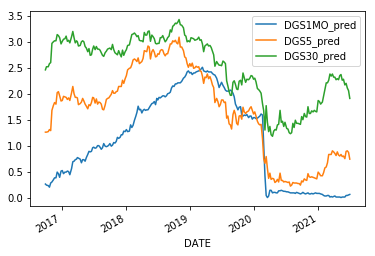

In [11]:
Y.plot()

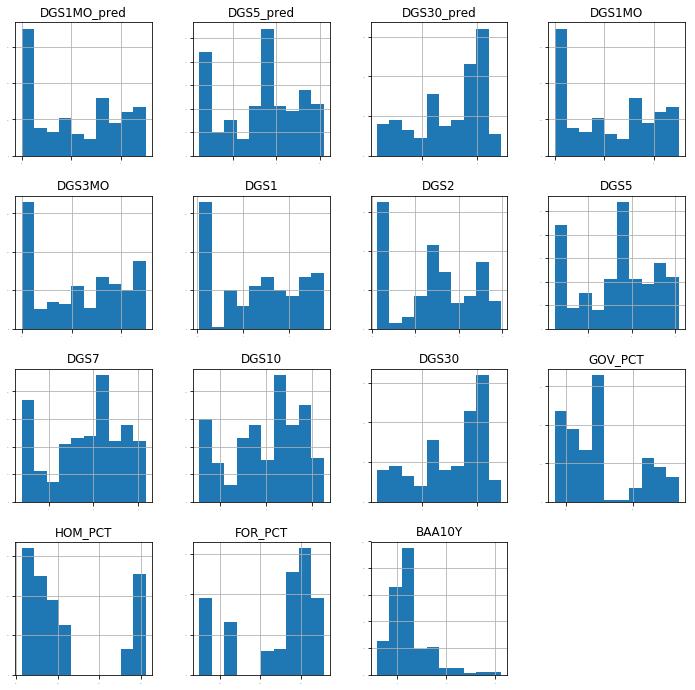

In [12]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

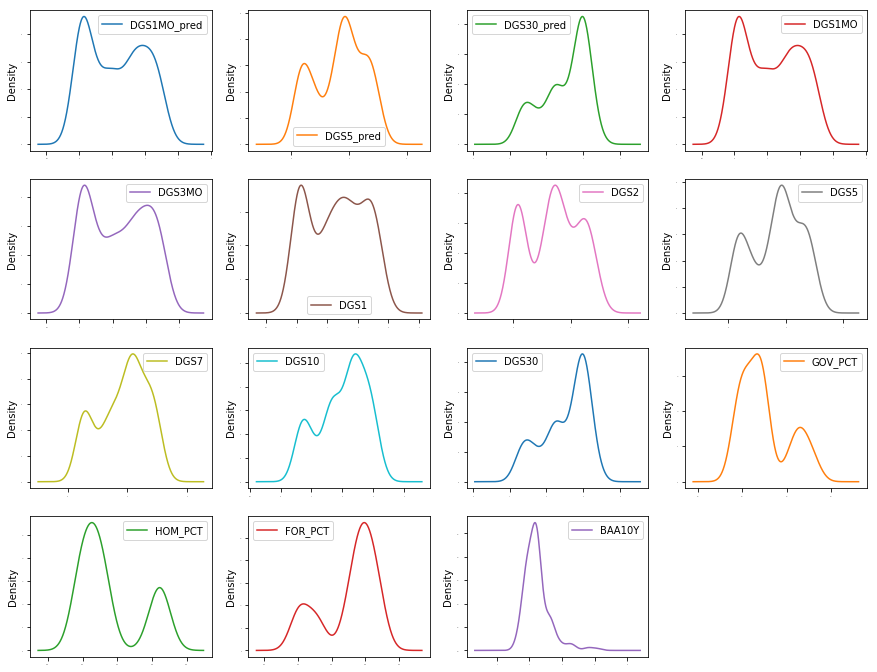

In [13]:
# density
dataset.plot(kind='density', subplots=True, layout=(5,4), sharex=False, legend=True, fontsize=1, figsize=(15,15))
pyplot.show()

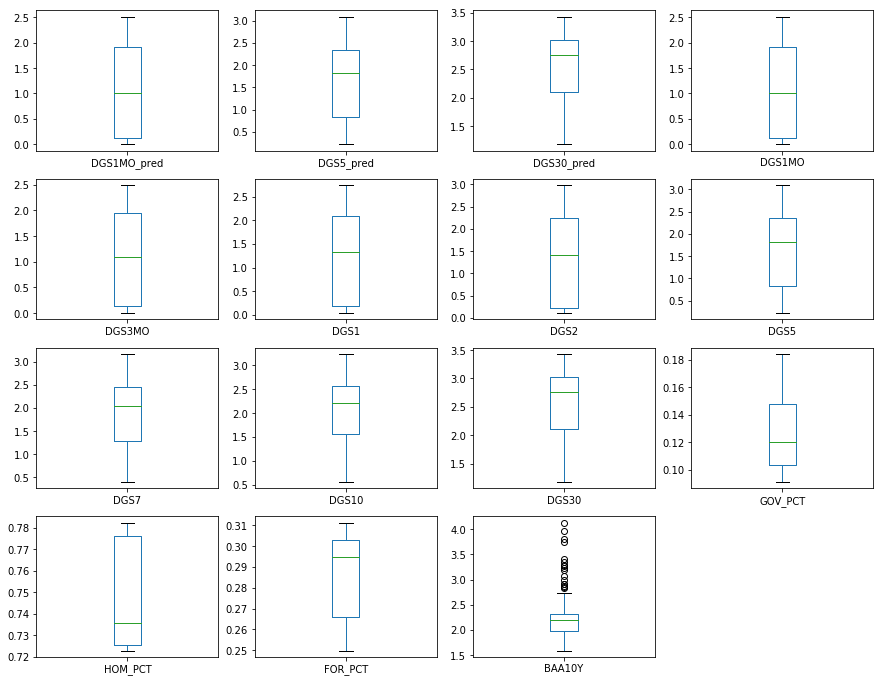

In [14]:
#Box and Whisker Plots
dataset.plot(kind='box', subplots=True, layout=(5,4), sharex=False, sharey=False, figsize=(15,15))
pyplot.show()

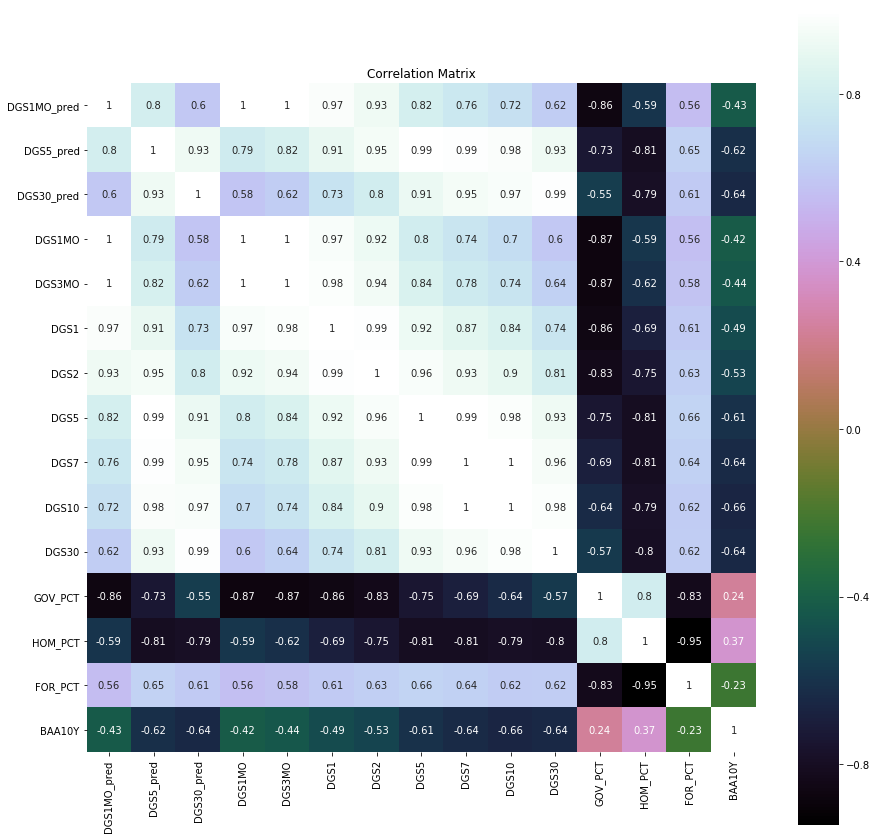

In [15]:
# correlation
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')



Form the correlation plot, we see that the 1 month and the 30 year yield data points are negatively autocorrelated. The 5 year yield also seems toe be negativly correlated with the changes in foreign goverment purchases.

<Figure size 1080x1080 with 0 Axes>

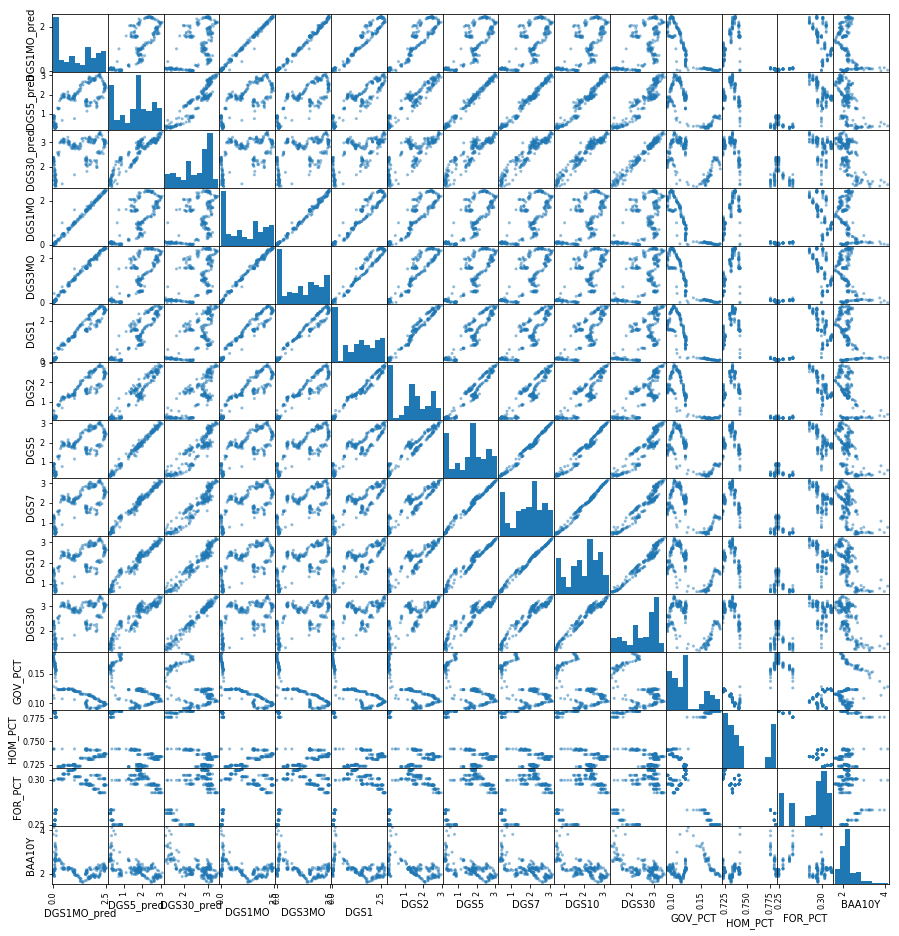

In [16]:
# Scatterplot Matrix
pyplot.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(15,16))
pyplot.show()

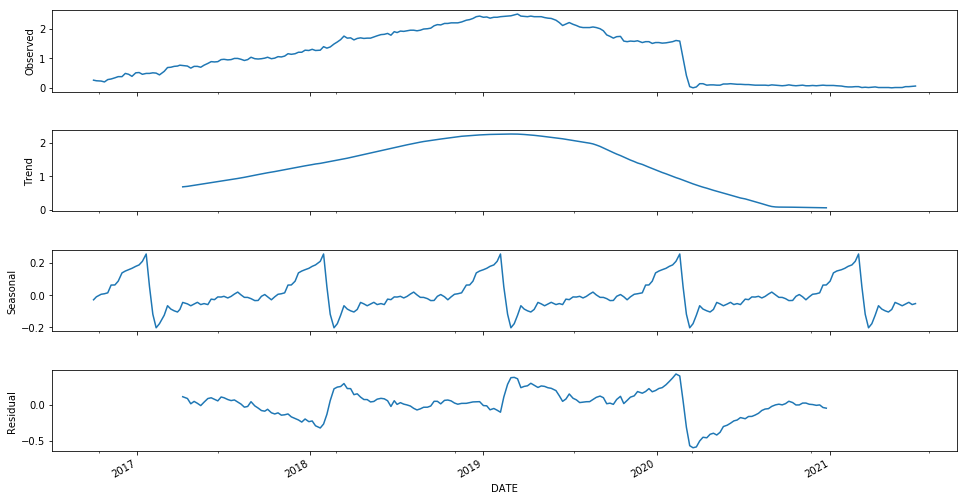

In [17]:
### Time Series Analysis
##1 Month

temp_Y = dataset['DGS1MO_pred']
res = sm.tsa.seasonal_decompose(temp_Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

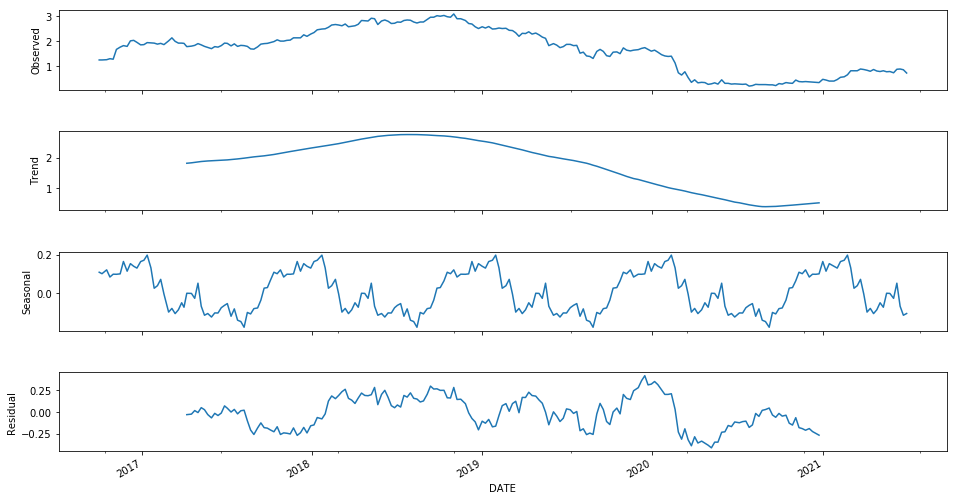

In [18]:
#5 year
temp_Y = dataset['DGS5_pred']
res = sm.tsa.seasonal_decompose(temp_Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

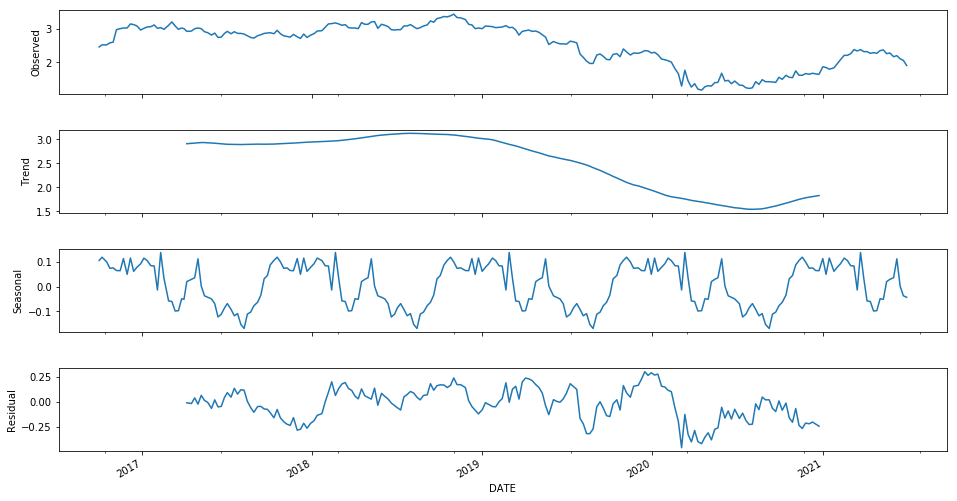

In [19]:
#30 years
temp_Y = dataset['DGS30_pred']
res = sm.tsa.seasonal_decompose(temp_Y,freq=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

Around Q1 2018, we observe a trend decrease in the 1 Month, 5 year and 30 year. However, the trend is most pronounced in the 1 month series.

### Data Preparation and analysis

#### Univariate Feature Selection


In [20]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X,temp_Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    print(col)
    print(featureScores.nlargest(10,'Score'))  #print 10 best features
    print('--------------')



DGS1MO_pred
     Specs      Score
1   DGS3MO  33720.025
0   DGS1MO  33500.443
2     DGS1   3916.598
3     DGS2   1475.034
8  GOV_PCT    702.576
4     DGS5    476.686
5     DGS7    323.605
6    DGS10    255.331
7    DGS30    150.502
9  HOM_PCT    128.449
--------------
DGS5_pred
     Specs      Score
4     DGS5  21134.619
5     DGS7  10631.578
6    DGS10   4818.562
3     DGS2   2412.698
7    DGS30   1440.933
2     DGS1   1112.598
1   DGS3MO    498.255
9  HOM_PCT    448.818
0   DGS1MO    388.484
8  GOV_PCT    277.894
--------------
DGS30_pred
      Specs     Score
7     DGS30  9247.682
6     DGS10  3523.629
5      DGS7  2157.399
4      DGS5  1218.916
3      DGS2   412.894
9   HOM_PCT   406.677
2      DGS1   268.243
11   BAA10Y   167.819
1    DGS3MO   152.305
10  FOR_PCT   143.056
--------------


As expected, based on the univariate feature selection, all the time series are most dependent on the previous changes.

### Evaluate Algorithms and Models

In [21]:
#split out validation dataset for the end

validation_size = 0.2

#In case the data is not dependent on the time series, then train and test split randomly
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [22]:
# test options for regression
num_folds = 10
scoring = 'neg_mean_squared_error'

In [23]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
#Neural Network
models.append(('MLP', MLPRegressor()))

In [24]:
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)

    # Finally we Train on the full period and test against validation
    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation))
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train))
    train_results.append(train_result)
    
    msg = "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s" % \
    (name, str(cv_results.mean()), str(cv_results.std()), str(train_result), str(validation_result))
    print(msg)
    print('----------')

LR: 
Average CV error: 0.007079724272752767 
Std CV Error: (0.002684141285447589) 
Training Error:
DGS1MO_pred    0.003
DGS5_pred      0.007
DGS30_pred     0.007
dtype: float64 
Test Error:
DGS1MO_pred    0.003
DGS5_pred      0.011
DGS30_pred     0.013
dtype: float64
----------
LASSO: 
Average CV error: 0.6095940182083726 
Std CV Error: (0.09051911700071584) 
Training Error:
DGS1MO_pred    0.725
DGS5_pred      0.712
DGS30_pred     0.369
dtype: float64 
Test Error:
DGS1MO_pred    0.775
DGS5_pred      0.803
DGS30_pred     0.406
dtype: float64
----------
EN: 
Average CV error: 0.4034668807683082 
Std CV Error: (0.0710230716647711) 
Training Error:
DGS1MO_pred    0.395
DGS5_pred      0.426
DGS30_pred     0.369
dtype: float64 
Test Error:
DGS1MO_pred    0.426
DGS5_pred      0.480
DGS30_pred     0.406
dtype: float64
----------
KNN: 
Average CV error: 0.009162860350877192 
Std CV Error: (0.005597295920432878) 
Training Error:
DGS1MO_pred    0.003
DGS5_pred      0.007
DGS30_pred     0.007
dtyp

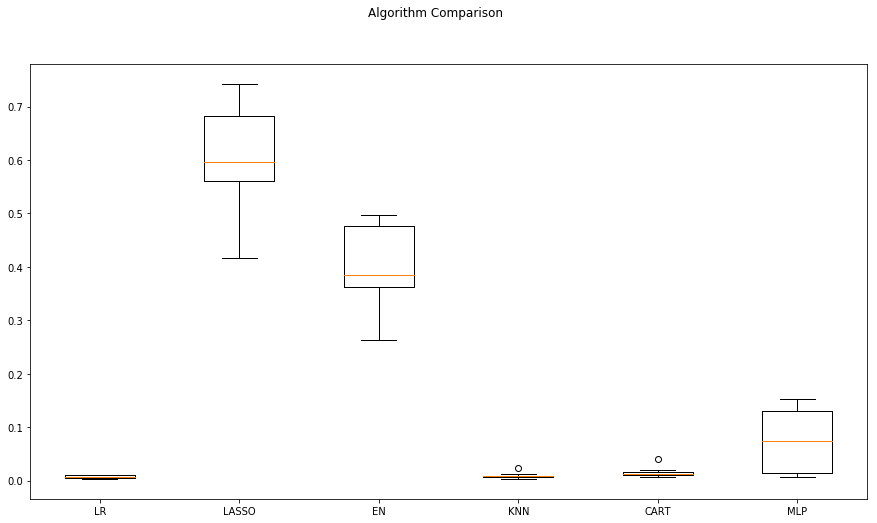

In [25]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

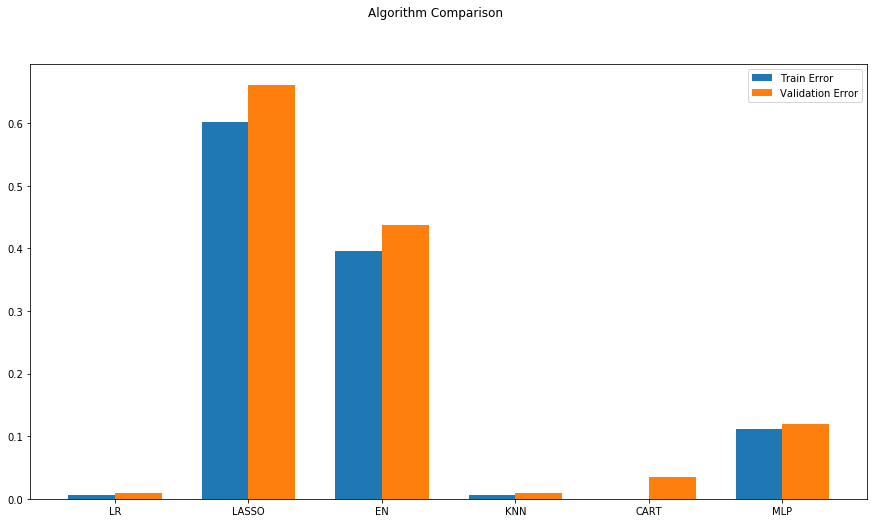

In [26]:
# compare algorithms
fig = pyplot.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, [x.mean() for x in train_results],  width=width, label='Train Error')
pyplot.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()



### Model Tuning and Grid Search

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
'''
hidden_layer_sizes : tuple, length = n_layers - 2, default (100,)
    The ith element represents the number of neurons in the ith
    hidden layer.
'''
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.019454 using {'hidden_layer_sizes': (50,)}
-0.058770 (0.044354) with: {'hidden_layer_sizes': (20,)}
-0.019454 (0.009787) with: {'hidden_layer_sizes': (50,)}
-0.031847 (0.020041) with: {'hidden_layer_sizes': (20, 20)}
-0.043441 (0.039134) with: {'hidden_layer_sizes': (20, 30, 20)}


### Finalise the Model

In [30]:
# prepare model
model = MLPRegressor(hidden_layer_sizes= (20, 30, 20))
model.fit(X_train, Y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(20, 30, 20), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

### Results and comparison of Regression and MLP

In [31]:
# estimate accuracy on validation set
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
predictions = model.predict(X_validation)
mse_MLP = mean_squared_error(Y_validation, predictions)
r2_MLP = r2_score(Y_validation, predictions)

# prepare model
model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
predictions_2 = model_2.predict(X_validation)

mse_OLS = mean_squared_error(Y_validation, predictions_2)
r2_OLS = r2_score(Y_validation, predictions_2)
print("MSE Regression = %f, MSE MLP = %f" % (mse_OLS, mse_MLP ))
print("R2 Regression = %f, R2 MLP = %f" % (r2_OLS, r2_MLP ))

MSE Regression = 0.009231, MSE MLP = 0.013212
R2 Regression = 0.982296, R2 MLP = 0.976779


The statistics of MLP and Linear regression are comparable. Let us check the prediction shape on the validation set.

### Predictions - 5 Year - MLP


In [32]:

train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes= (50,))
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, Y_train)
model_OLS = modelOLS.fit(X_train, Y_train)

Y_predMLP = pd.DataFrame(model_MLP.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

Y_predOLS = pd.DataFrame(model_OLS.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)


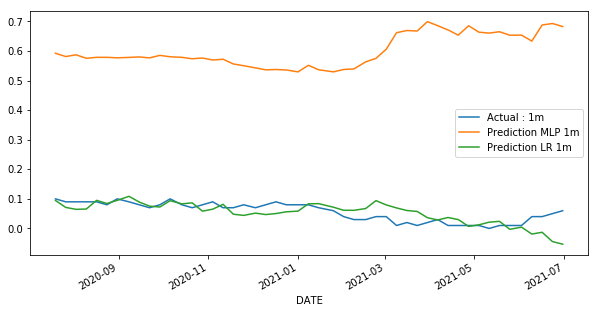

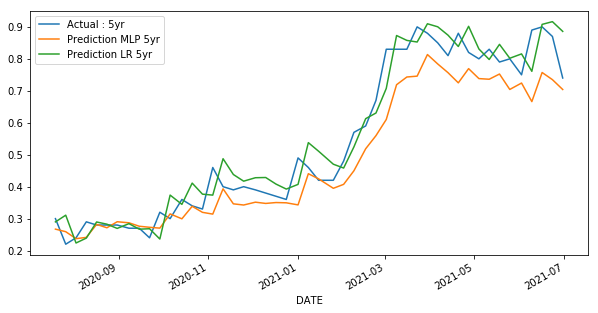

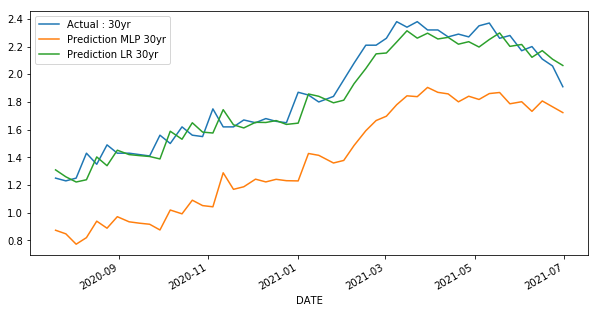

In [34]:
pd.DataFrame({'Actual : 1m': Y_validation.loc[:, 'DGS1MO_pred'],
              'Prediction MLP 1m': Y_predMLP.loc[:, 'DGS1MO_pred'],
              'Prediction LR 1m': Y_predOLS.loc[:, 'DGS1MO_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 5yr': Y_validation.loc[:, 'DGS5_pred'],
              'Prediction MLP 5yr': Y_predMLP.loc[:, 'DGS5_pred'],
              'Prediction LR 5yr': Y_predOLS.loc[:, 'DGS5_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 30yr': Y_validation.loc[:, 'DGS30_pred'],
              'Prediction MLP 30yr': Y_predMLP.loc[:, 'DGS30_pred'],
              'Prediction LR 30yr': Y_predOLS.loc[:, 'DGS30_pred']}).plot(figsize=(10,5))


Overall, the regression and MLP are comparable, however, for 1m tenor, the fitting with MLP is slighly poor as compared to the regression. However,the multitask learning with neural network is more intuitive for modeling many time series simultaneously.

### Summary

The linear regression model, despite its simplicity, is a tough benchmark to beat for such one step ahead forecasting, given the dominant characteristic of the last available value of the variable to predict. The ANN results in this case study are comparable to the linear regression models.

The good thing about ANN is that it is more flexible to changing market conditions. Also, ANN models can be enhanced by performing grid search on several other hyperparameters and using recurrent neural network such as LSTM.
